In [20]:
import numpy as np
import pandas as pd
import os
from pandas import read_csv
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'] # 给数据添加表头
data=pd.read_csv('./housing data.csv',header = None,delimiter = r"\s+",names=column_names)
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 可以看到数据一共有13个特征，一个标签，且无缺失值，ZN与CHAS列数据分布异常，猜测后续回归过程不需要用这些数据
### 对于MEDV列，有多个值为50的数据，猜测是数据遗失后手动填补或不宜透露更高房价，应删除

In [21]:
data = data[(data['MEDV'] < 50.0)]
(np.shape(data))

(490, 14)

### 再画图看看各数据的分布

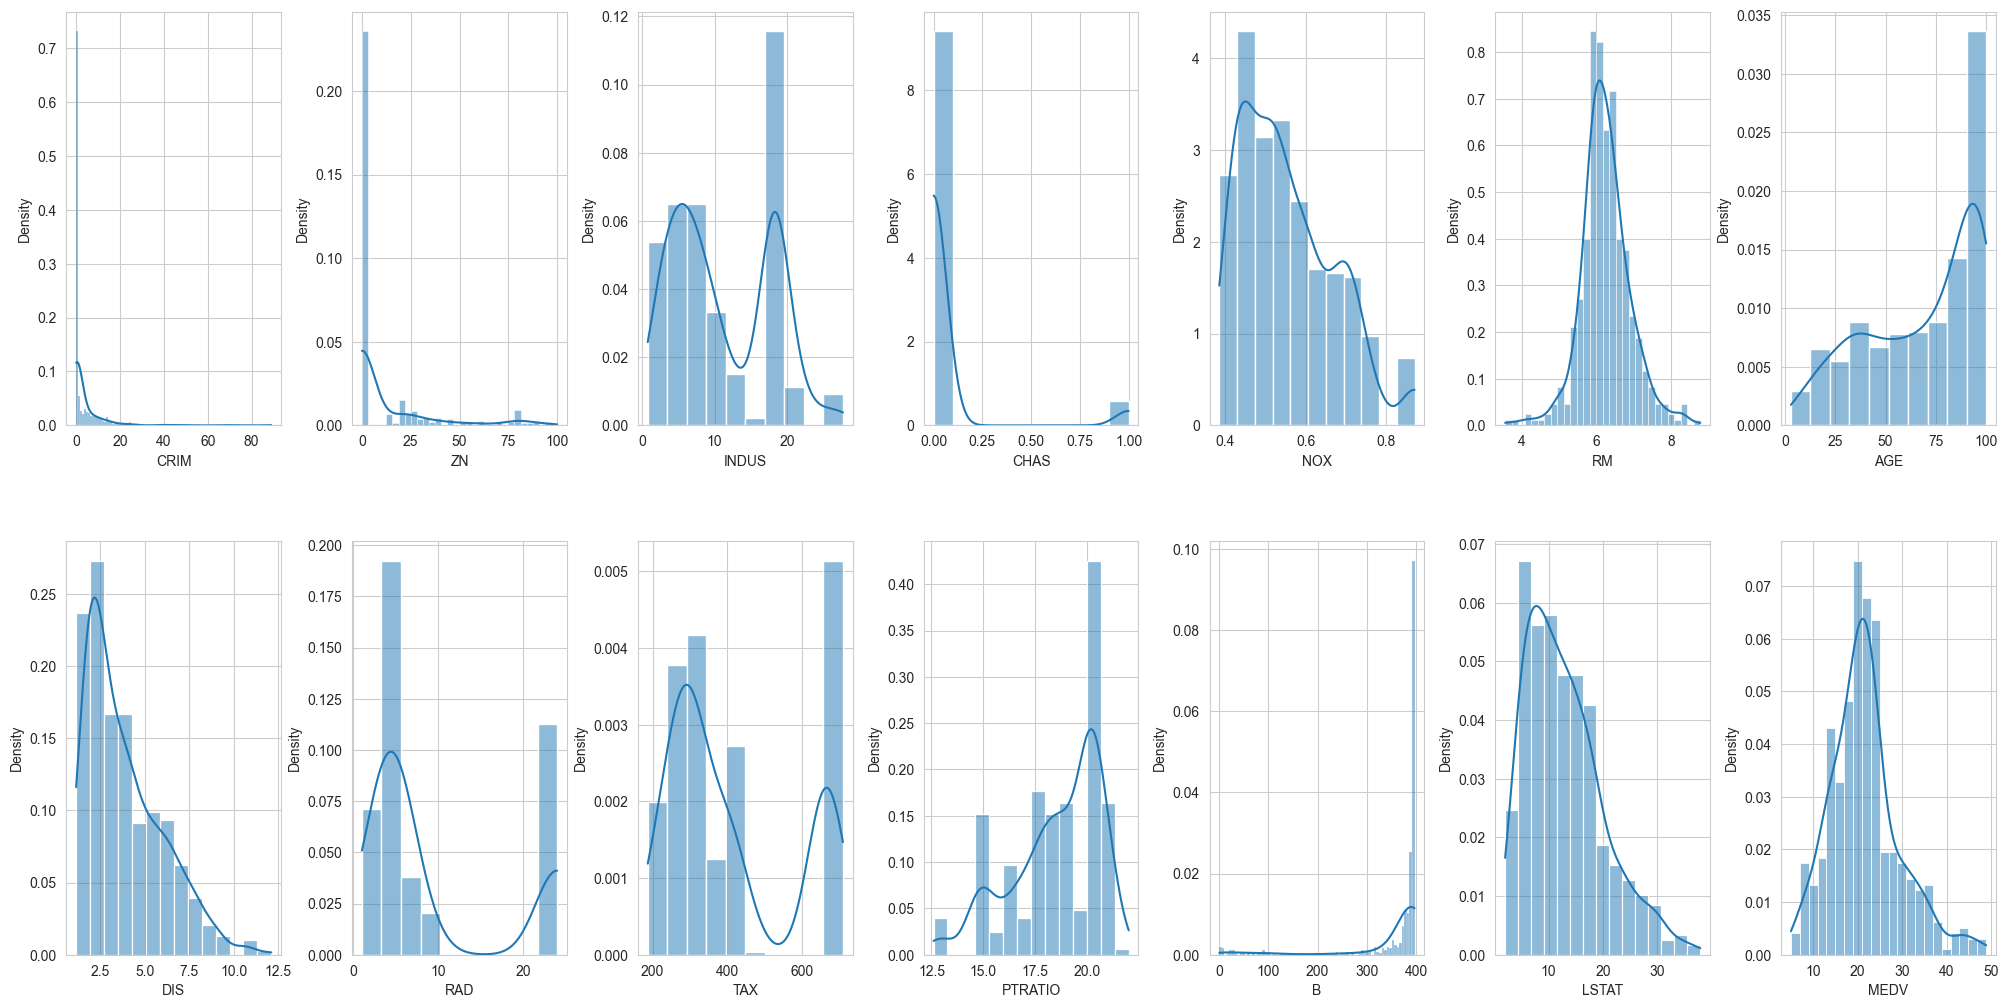

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.histplot(v, ax=axs[index],kde=True,stat="density")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### 从直方图可以看出，CRIM、ZN、B列具有高度偏斜的分布，MEDV类似于正态分布，除了CHAS这一离散变量外，都具有常态或双模型分布。

<Axes: >

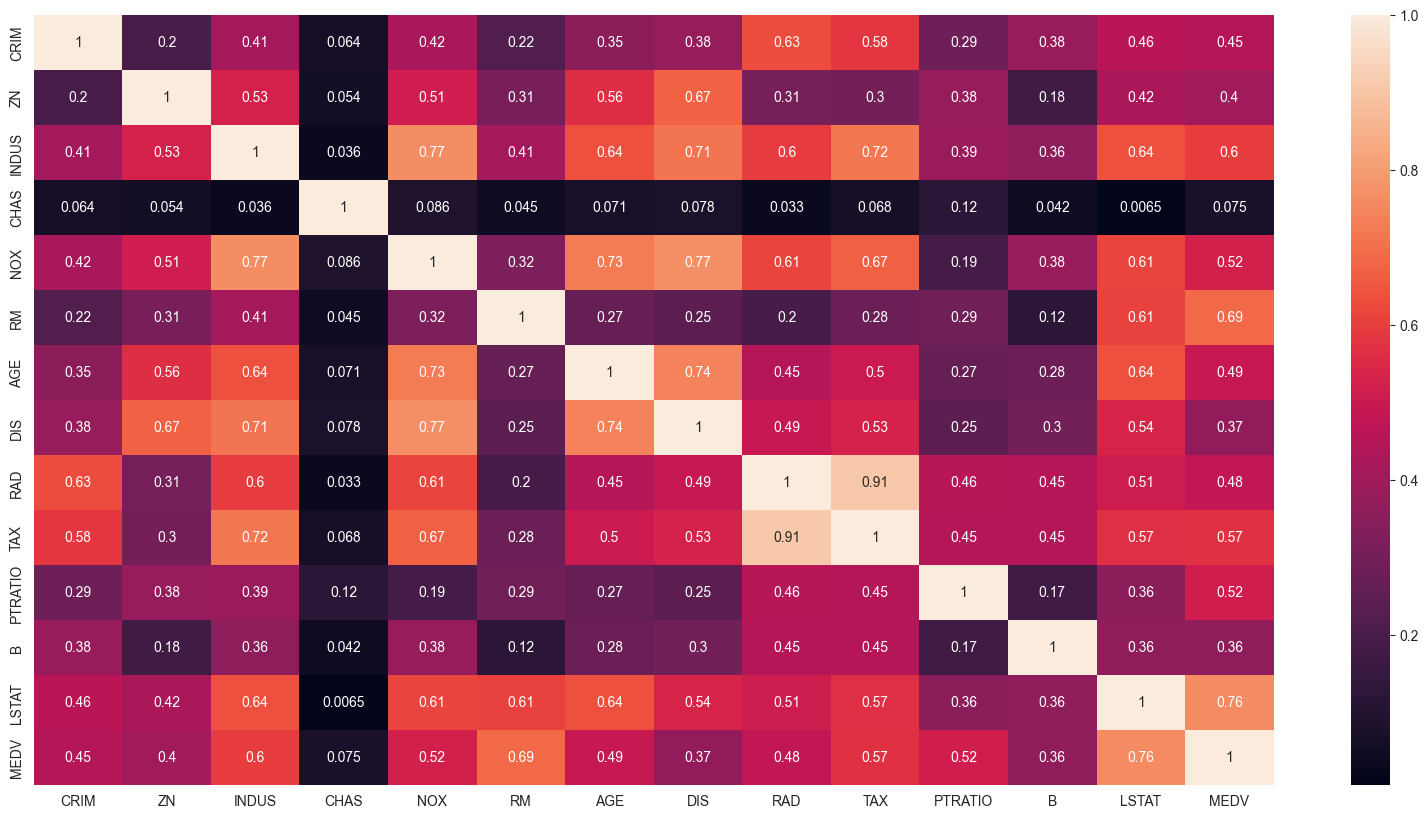

In [23]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

### 从相关矩阵中，可以看出TAX和RAD是高度相关的特征，LSTAT、INDUS、RM、TAX、NOX、PTRAIO、AGE列与MEDV的相关分数都高于0.5，故可以根据这些特征来预测MEDV

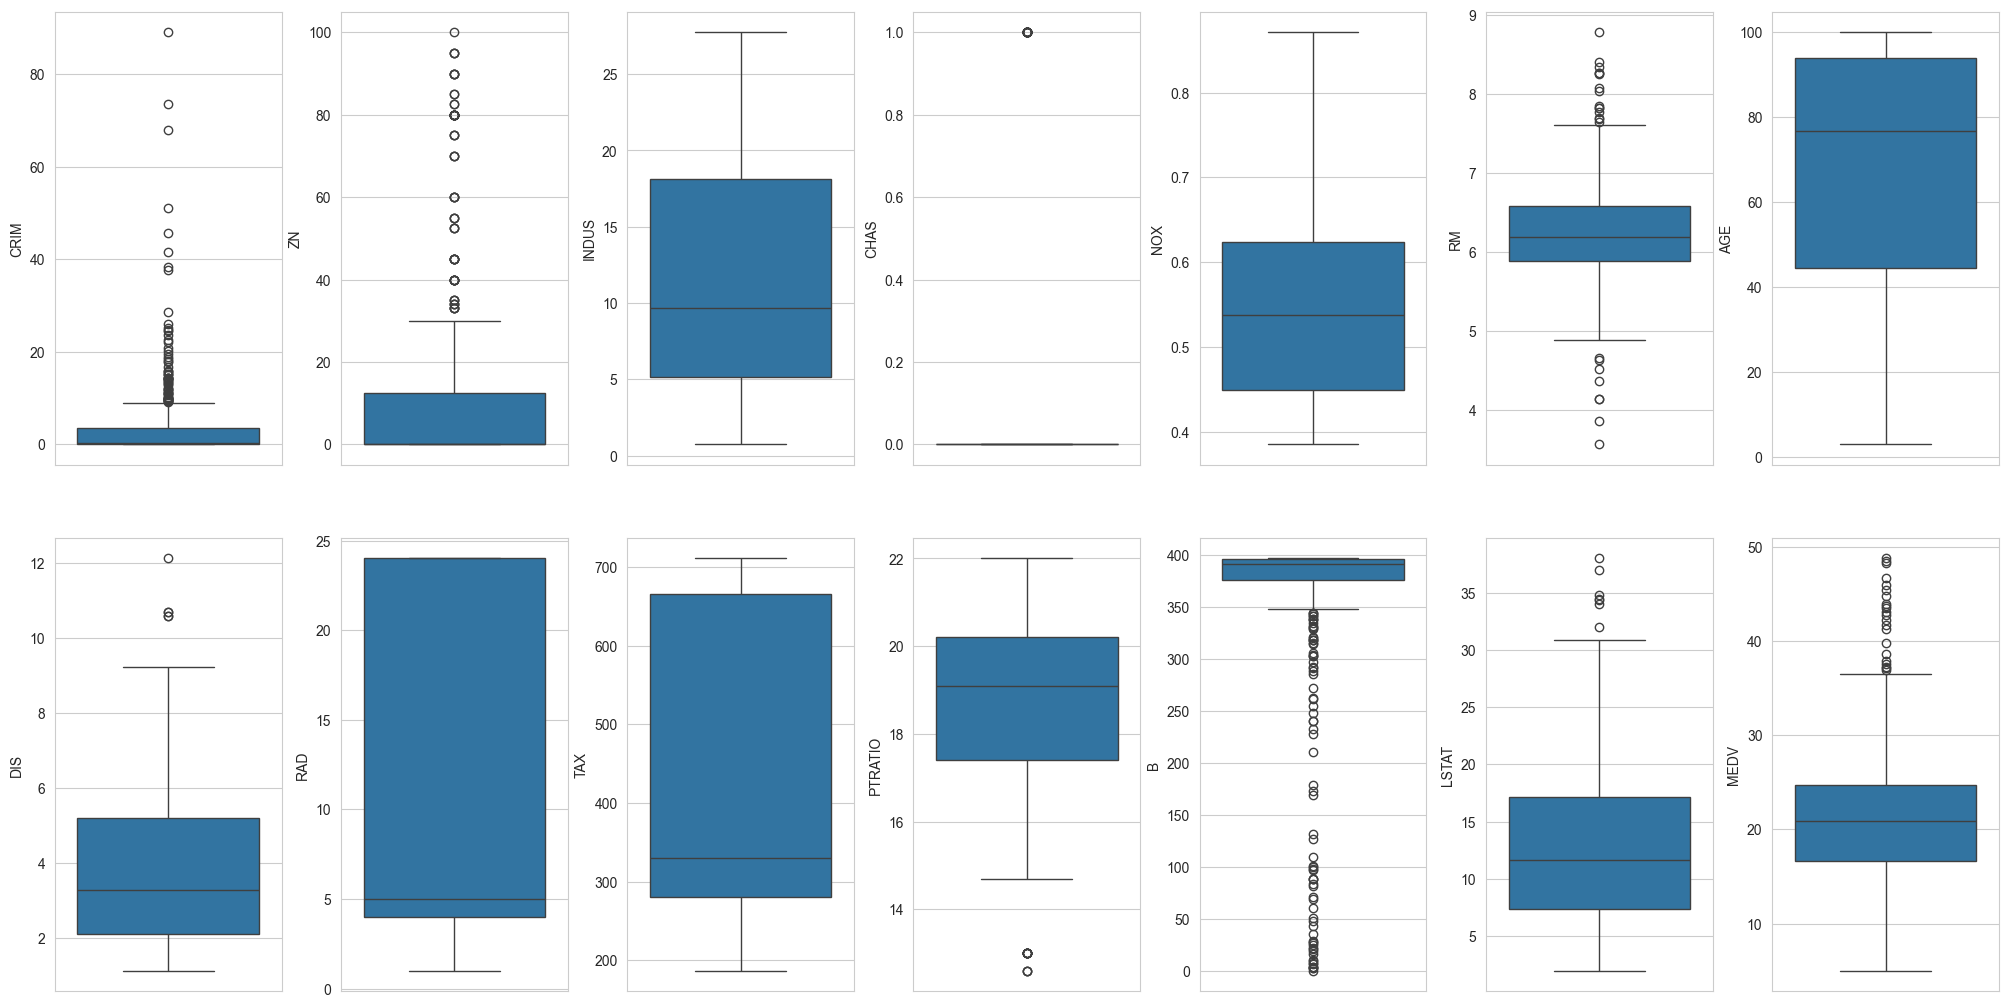

In [24]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### 由箱型图可以看到RM、PORATIO、LATAT、TAX中似乎有异常值，会对模型结果造成影响。

In [25]:
# 数据集筛选
column_s = ['INDUS', 'NOX', 'RM', 'AGE', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV']
data1 = data.loc[:,column_s] #所需数据集

In [26]:
# 数据划分
import random
random.seed(0) #随记结果复现
train_size = int(len(data1)*0.8) #训练集大小
test_size = int(len(data1)*0.2) #测试集大小
idx = list(data1.index)
random.shuffle(idx)     # 随机打乱

In [27]:
column_sels = ['INDUS', 'NOX', 'RM', 'AGE', 'TAX', 'PTRATIO', 'LSTAT'] # 选取所需要的特征
x = data1.loc[:,column_sels] #特征值
y = data1['MEDV'] #标签值

### 由于后面要用梯度下降法，故先将数据归一化，加速梯度下降的收敛，防止过度扭曲

In [28]:
# 采用Z-score归一 使数据符合正态分布
x = (x-x.mean(axis=0))/(x.std(axis=0))
print(x)

        INDUS       NOX        RM       AGE       TAX   PTRATIO     LSTAT
0   -1.290537 -0.139752  0.504524 -0.109320 -0.666420 -1.525721 -1.121533
1   -0.592723 -0.731074  0.268743  0.377103 -0.987724 -0.341155 -0.534226
2   -0.592723 -0.731074  1.438464 -0.254892 -0.987724 -0.341155 -1.255654
3   -1.309595 -0.825342  1.152158 -0.798123 -1.106726  0.085289 -1.409539
4   -1.309595 -0.825342  1.380284 -0.499879 -1.106726  0.085289 -1.072120
..        ...       ...       ...       ...       ...       ...       ...
501  0.119751  0.160194  0.532083  0.029151 -0.803272  1.175089 -0.459401
502  0.119751  0.160194 -0.192103  0.298991 -0.803272  1.175089 -0.542697
503  0.119751  0.160194  1.118475  0.806717 -0.803272  1.175089 -1.028355
504  0.119751  0.160194  0.839824  0.746358 -0.803272  1.175089 -0.909764
505  0.119751  0.160194 -0.329897  0.444563 -0.803272  1.175089 -0.712112

[490 rows x 7 columns]


### 画图看看效果

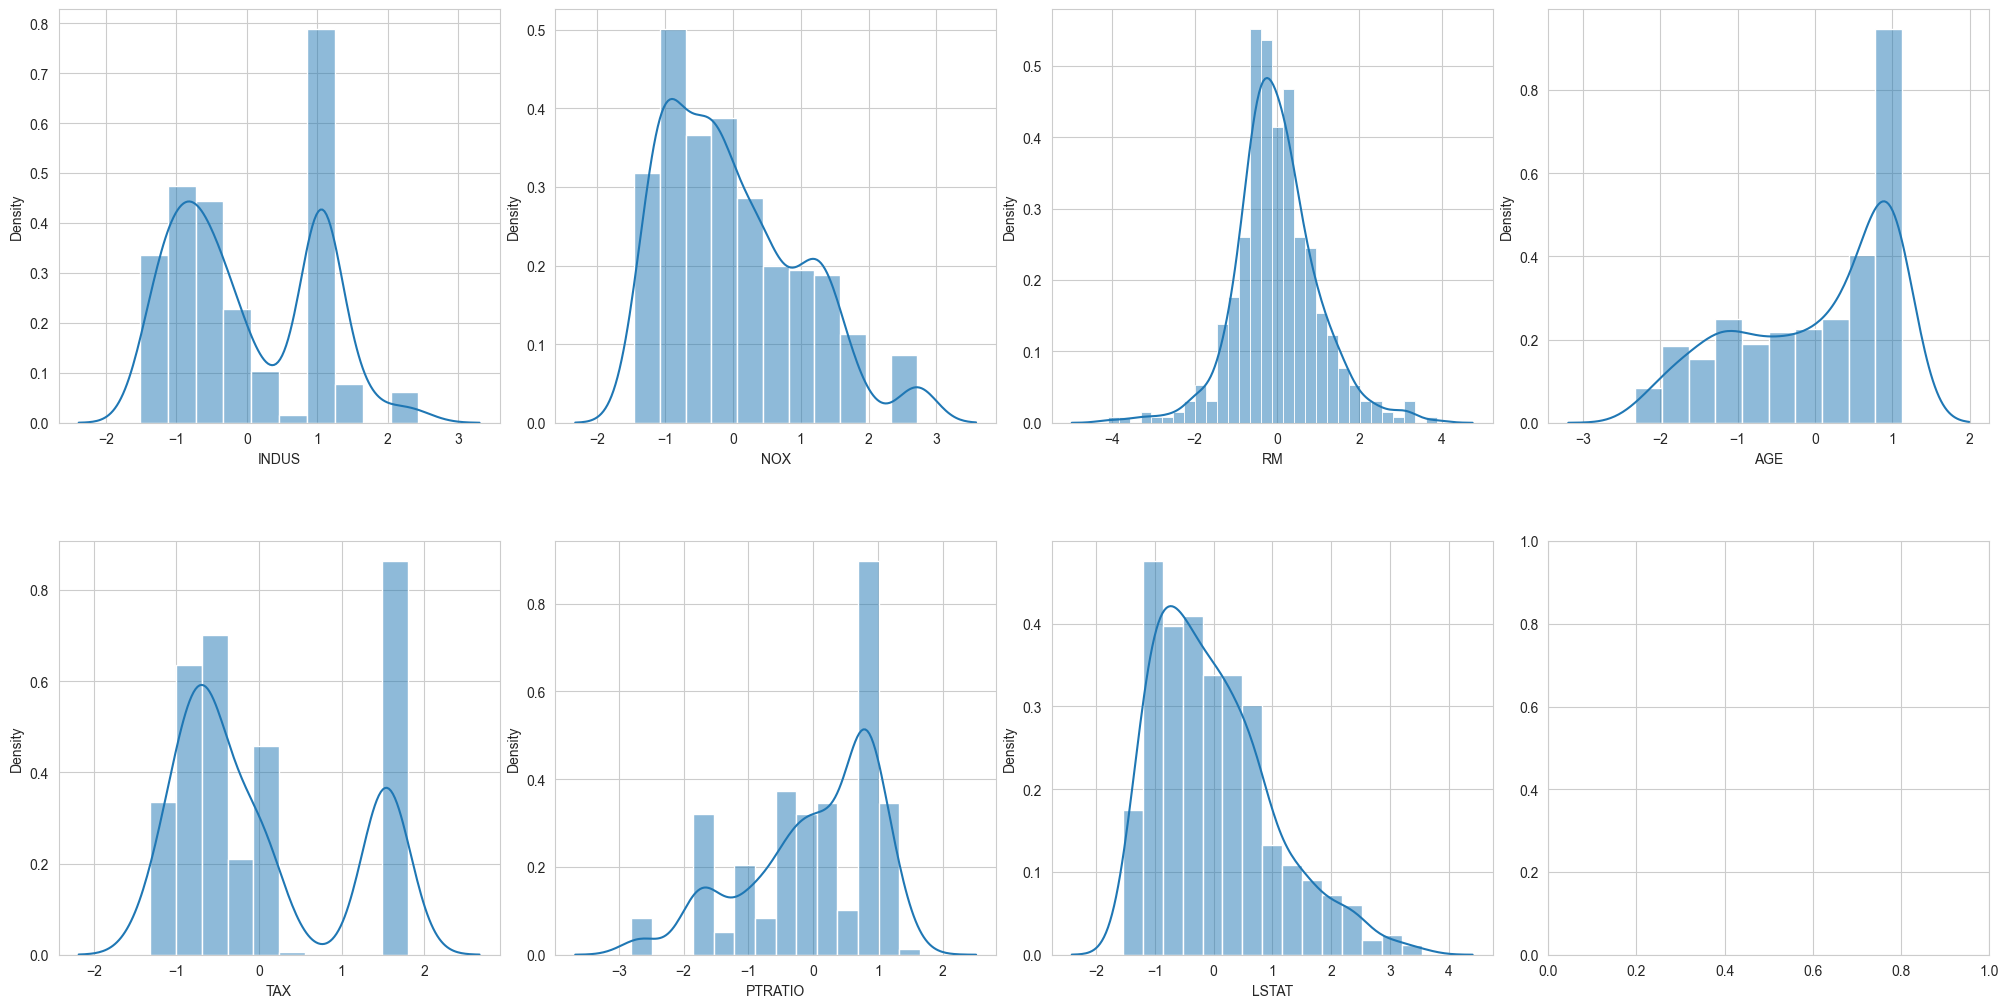

In [29]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in x.items():
    sns.histplot(v, ax=axs[index],kde=True,stat="density", kde_kws=dict(cut=3))
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### 对比之前的直方图，尤其是NOX、LSTAT列，曲线更为平滑，更加符合正态分布

In [30]:
x.insert(0,"x0",1) #插入值为1的列，计算截距
x_train = x.loc[idx[:train_size]] 
x_test = x.loc[idx[train_size:]]
y_train = y.loc[idx[:train_size]] #标签值
y_test = y.loc[idx[train_size:]]
x_train

,x0,INDUS,NOX,RM,AGE,TAX,PTRATIO,LSTAT
350,1,-1.445933,-1.073869,0.374385,-0.847831,-0.434367,0.559115,-0.980354
340,1,-0.868330,-0.336859,-0.424822,-0.347206,-1.094825,0.796028,-0.513049
300,1,-1.300799,-1.322395,0.957714,-0.741315,-0.297516,-1.762634,-0.967647
58,1,-0.877126,-0.868192,-0.153827,-1.387512,-0.737821,0.559115,-0.856116
431,1,1.024270,0.254462,0.899535,0.923885,1.535106,0.796028,0.955218
...,...,...,...,...,...,...,...,...
235,1,-0.720265,-0.405418,-0.244158,-0.240690,-0.600969,-0.530685,-0.288574
147,1,1.241238,2.714017,-2.020174,0.973592,-0.029763,-1.810016,2.344424
311,1,-0.177846,-0.088333,-0.189041,-0.549586,-0.618820,-0.056859,-0.980354
411,1,1.024270,0.365871,0.630070,1.126265,1.535106,0.796028,1.171223


In [42]:
# 最小二乘 求特征系数
x_t = x_train.T
x_t_x = np.dot(x_t,x_train)
x_ni =np.linalg.inv(x_t_x)
x_ni_t = np.dot(x_ni,x_t)
w = np.dot(x_ni_t,y_train)
y_pred = np.dot(x_test,w)
print(w)

[ 2.16270256e+01 -4.61299257e-03 -4.01496696e-01  2.42093278e+00
  2.20610799e-01 -9.85686303e-01 -1.67391608e+00 -3.14152025e+00]


### 可以看到RM(第四个)和LSTAT(最后一个)的系数绝对值都高于2.5，这符合之前相关矩阵中的数据，结合特征值的意义，房间数RM确实是影响房价最重要的因素，区域的低收入阶层占比LSTAT越多，房价越低，毕竟要住户买得起才行。

In [32]:
df = pd.DataFrame ({'实际房价': y_test, '预测房价': y_pred})
df

,实际房价,预测房价
456,12.7,14.686289
287,23.2,26.482476
435,13.4,15.176866
505,11.9,21.923462
63,25.0,25.009286
...,...,...
222,27.5,27.023724
471,19.6,18.991965
404,8.5,9.373852
203,48.5,35.943115


### 对比预测房价与实际房价，可以看到大部分误差都在2以内，可以再画图看看

Text(30, 40, 'Least Squares predict line')

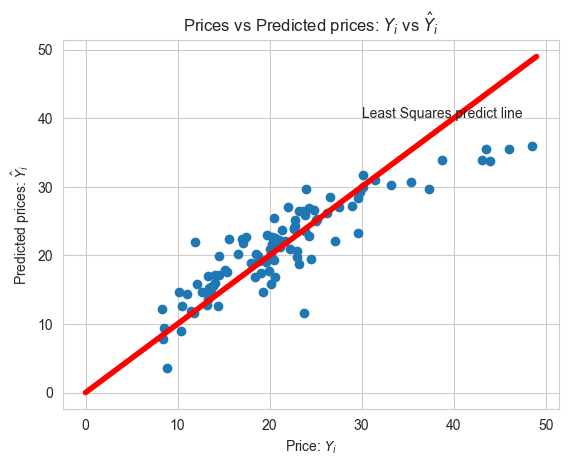

In [33]:
plt.scatter(y_test, y_pred) # 生成散点图 
plt.xlabel("Price: $Y_i$") # 实际值
plt.ylabel("Predicted prices: $\\hat{Y}_i$") #预测值
plt.title("Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$")
x = np.arange(0, 50)
y = x
plt.plot(x, y, color = 'red', lw = 4)
plt.text(30,40, "Least Squares predict line")

### 在代码功能实现层面，我们知道，如果预测房价和实际房价一致的话，那么所有的数据点都应汇集在y=x这条线上，但这并不是现实。可以看到，除了少数点，大部分点散落在y=x附近，大趋势说明预测的结果还不错

In [34]:
# 计算均方误差
MSEi = (y_test-y_pred)**2
MSE = MSEi.sum()/len(MSEi)
MSE

16.02773640813123

### 均方误差小于20，还算可以

### 下面试试梯度下降算法

In [51]:
def gradient_function(thetas,x,y):
    '''计算梯度
    '''
    x_thetas = np.dot(x,thetas)
    y = np.array(y)
    y = y.reshape(y.shape[0],1) #将y转为二维数组，不然不拿与x_thetas相减
    x_thetas_y = x_thetas-y
    gradient = (1/x.shape[0])*np.dot(x.T,x_thetas_y)
    #loss.append(x_thetas_y**2)
    return gradient

def gradient_descent(x,y,alpha):
    '''梯度下降迭代计算
    '''
    thetas = np.zeros(x.shape[1]).reshape(x.shape[1],1) #创建行数等于x列数的列向量
    gradient = gradient_function(thetas,x,y)
    while not np.all(np.absolute(gradient)<0.5):
        thetas = thetas-alpha*gradient
        gradient = gradient_function(thetas,x,y)
    return thetas
thetas = gradient_descent(x_train,y_train,0.01)
thetas

array([[21.12208355],
       [-0.56929434],
       [-0.15046476],
       [ 2.48398137],
       [ 0.04547991],
       [-0.83476281],
       [-1.51759292],
       [-2.83237016]])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (378, 392) + inhomogeneous part.

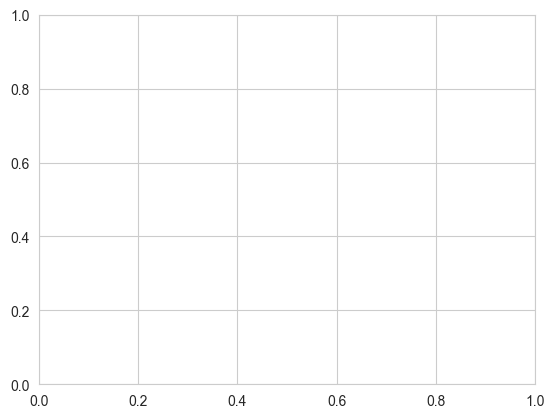

In [50]:
plt.plot(len(loss),loss)
plt.title('残差过程图')
plt.xlabel('迭代次数')
plt.ylabel('残差值')

### 结果与最小二乘法类似，RM影响最大，LSTAT其次

In [ ]:
y_pred1=np.dot(x_test,thetas)
y_pred1 = y_pred1.flatten()
df1 = pd.DataFrame ({'实际房价': y_test, '预测房价': y_pred1})
df1

In [ ]:
plt.scatter(y_test, y_pred1) # 生成散点图 
plt.xlabel("Price: $Y_i$") # 实际值
plt.ylabel("Predicted prices: $\\hat{Y}_i$") #预测值
plt.title("Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$")

x = np.arange(0, 50)
y = x
plt.plot(x, y, color = 'red', lw = 4)
plt.text(30,40, "Gradient Descent predict line")

In [ ]:
# 计算均方误差
MSEi1 = (y_test-y_pred1)**2
MSE1 = MSEi1.sum()/len(MSEi1)
MSE1

### 均方误差也非常接近